# Registering multiple frames to first frame

## Imports and magics

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import ot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from IPython.display import HTML

from otimage import imagerep, io 
from otimage.utils import plot_maxproj_units

## Implement EM-based OT registration

In [3]:
def _compute_ot(pts_1, pts_2, wts_1, wts_2):
    """Normalize weights and compute OT matrix."""
    
    # Normalize weights
    p_1 = wts_1 / np.sum(wts_1)
    p_2 = wts_2 / np.sum(wts_2)

    # Normalized distance matrix 
    M_nn = ot.dist(pts_1, pts_2, metric='sqeuclidean')
    M = M_nn / np.median(M_nn)
    
    # Compute transport plan
    return ot.emd(p_1, p_2, M, log=True)
    

def _ot_reg(pts_1, pts_2, p_mtx):
    """Compute weighted polynomial regression using OT plan"""
    
    # Get pairs of points with values above threshold, and corresponding weights from P matrix
    idx_1, idx_2 = np.nonzero(p_mtx)
    x = pts_1[idx_1]
    y = pts_2[idx_2]
    smp_wt = p_mtx[idx_1, idx_2]

    # Use sklearn to minimize cost function
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=3)),
        ('linear', LinearRegression(fit_intercept=True))
    ])
    model.fit(x, y, linear__sample_weight=smp_wt)

   
    return model


def ot_reg_poly(mp_1, mp_2, n_iter):
    """EM-based OT registration method with polynomial model."""
    
    model = [None] * n_iter
    p_mtx = [None] * n_iter
    ot_log = [None] * n_iter
    
    pts = [mp_1.pts] + [None] * n_iter
    
    for i in range(n_iter):
        
        # E-step: Compute OT between current points and target points
        p_mtx[i], ot_log[i] = _compute_ot(pts[i], mp_2.pts, mp_1.wts, mp_2.wts)
        
        # M-step: Compute new mapping using transport plan
        model[i] =  _ot_reg(mp_1.pts, mp_2.pts, p_mtx[i])
       
        # Update points 
        pts[i + 1] = model[i].predict(mp_1.pts)
       
    debug = {
        'model': model,
        'pts': pts,
        'p_mtx': p_mtx,
        'ot_log': ot_log,
    }
    
    return model[-1], debug

## Load data

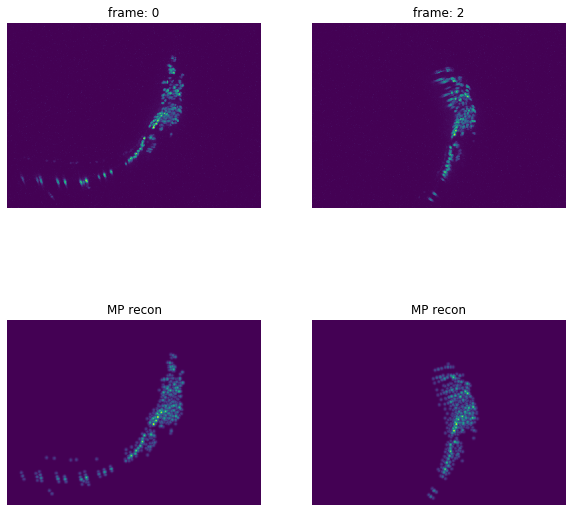

In [4]:
# Frames to load
t_start = 0
n_frames = 3
t_vals = range(t_start, t_start + n_frames)

# Load frames from dataset
img_path = '/home/mn2822/Desktop/WormOT/data/zimmer/raw/mCherry_v00065-00115.hdf5'
with io.ZimmerReader(img_path) as reader:
    units = reader.units
    img = [reader.get_frame(t) for t in t_vals]

# Load MP components
mp_path = '/home/mn2822/Desktop/WormOT/data/zimmer/mp_components/mp_0000_0050.h5'
with io.MPReader(mp_path) as reader:
    mp = [reader.get_frame(t) for t in t_vals]

# Reconstruct images from MPs
rec = [imagerep.reconstruct_mp_image(x, units) for x in mp]

# Indices to plot
k1 = 0
k2 = -1
  
plt.figure(figsize=(10, 10))

plt.subplot(221)
plot_maxproj_units(img[k1], units)
plt.title(f'frame: {t_vals[k1]}')
plt.axis('off')

plt.subplot(222)
plot_maxproj_units(img[k2], units)
plt.title(f'frame: {t_vals[k2]}')
plt.axis('off');

plt.subplot(223)
plot_maxproj_units(rec[k1], units)
plt.title('MP recon')
plt.axis('off')

plt.subplot(224)
plot_maxproj_units(rec[k2], units)
plt.title('MP recon')
plt.axis('off');

## Register all frames to first frame directly

In [5]:
models = [None] * (n_frames - 1)
debug = [None] * (n_frames - 1)

for t in range(n_frames - 1):
    models[t], debug[t] = ot_reg_poly(mp[0], mp[t + 1], 50)

## Inspect mappings by comparing reconstructions to real frames

### Reconstruct all frames by applying learned mapping to first frame

In [6]:
t_rec = [rec[0]] + [None] * (n_frames - 1)

for t in range(n_frames - 1):
    
    t_rec_pts = models[t].predict(mp[0].pts)
    t_mp = imagerep.ImageMP(t_rec_pts, mp[0].wts, mp[0].cov, mp[0].img_limits)
    t_rec[t + 1] = imagerep.reconstruct_mp_image(t_mp, units)

### Plot single frame next to reconstruction

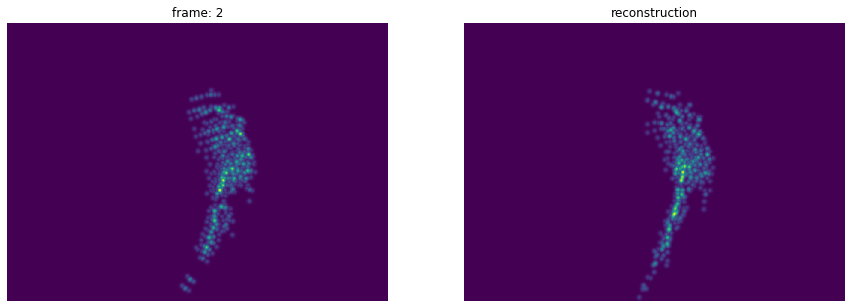

In [10]:
t = 2

plt.figure(figsize=(15, 15))

plt.subplot(121)
plot_maxproj_units(rec[t], units)
plt.title(f'frame: {t}')
plt.axis('off')
        
plt.subplot(122)
plot_maxproj_units(t_rec[t], units)
plt.title('reconstruction')
plt.axis('off');

### Create video of all frame reconstructions

In [11]:
fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(15, 15))

ax_1.set_title('frame')
ax_2.set_title('reconstruction')

ax_1.axis('off')
ax_2.axis('off')

def animate(t):
    plot_maxproj_units(rec[t], units, ax=ax_1, animated=True)
    plot_maxproj_units(t_rec[t], units, ax=ax_2, animated=True)
    
ani = animation.FuncAnimation(fig, animate, n_frames)

#ani.save('ot_reg_demo.mp4')

# Prevent double-display of animation
plt.close()

# Display animation in notebook
HTML(ani.to_html5_video())